In [45]:
import os
dir_path = os.getcwd()
import email
import email.policy as policy
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
from urlextract import URLExtract
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns

In [2]:
def multipart_to_text(mail):
    for part in mail.get_payload():
        if part.get_content_type() in ["text/plain", "text/html"]:
            return BeautifulSoup(part.get_content()).get_text().replace("\n\n", " ")
        else:
            return False

In [3]:
def read_mails(dir_name):
    global dir_path
    emails = []
    i = 1
    for filename in os.listdir(dir_name):
        with open("{}\\{}\\{}".format(dir_path, dir_name, filename)) as f:
            try:
                mail = email.parser.Parser(policy = policy.default).parse(f)
                if "multipart" in mail.get_content_type():
                    multipart_str = multipart_to_text(mail)
                    if multipart_str:
                        emails.append(multipart_str)
                else:
                    emails.append(BeautifulSoup(mail.get_content()).get_text().replace("\n\n", " "))
            except:
                continue
            
    return emails

In [4]:
spam_mails = read_mails("Spam\\spam")
spam_2_mails = read_mails("Spam\\spam_2")
ham_mails = read_mails("Ham\\easy_ham")
ham_2_mails = read_mails("Ham\\easy_ham_2")
ham_hard_mails = read_mails("Ham\\hard_ham")

In [109]:
print(ham_mails[0])

Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues 
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com> 
  | I can't reproduce this error. For me it is very repeatable... (like every time, without fail). This is the debug log of the pick happening ... 18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ... Note, if I run the pick command by hand ... delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ... delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 ICT 2002] And the relevant part of my .mh_profile 

In [6]:
print(spam_mails[0])

       Save up to 70% on Life Insurance.
Why Spend More Than You Have To? Life Quote Savings     
Ensuring your 
      family's financial security is very important. Life Quote Savings makes 
      buying life insurance simple and affordable. We Provide FREE Access to The 
      Very Best Companies and The Lowest Rates.   Life Quote Savings is FAST, EASY and 
            SAVES you money! Let us help you get started with the best values in 
            the country on new coverage. You can SAVE hundreds or even thousands 
            of dollars by requesting a FREE quote from Lifequote Savings. Our 
            service will take you less than 5 minutes to complete. Shop and 
            compare. SAVE up to 70% on all types of Life insurance!   Click Here For Your 
            Free Quote! Protecting your family is the best investment you'll ever 
          make!    
If you are in receipt of this email 
      in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMO

In [7]:
print("Number of mails in spam =", len(spam_mails))
print("Number of mails in spam_2 =", len(spam_2_mails))
print("Number of mails in easy_ham =", len(ham_mails))
print("Number of mails in easy_ham_2 =", len(ham_2_mails))
print("Number of mails in hard_ham =", len(ham_hard_mails))
print()
print("Total number of spam mails =", len(spam_mails) + len(spam_2_mails))
print("Total number of ham mails =", len(ham_mails) + len(ham_2_mails) + len(ham_hard_mails))
print()
print("Percentage of spam mails =", (len(spam_mails) + len(spam_2_mails)) / (len(spam_mails) + len(spam_2_mails) + len(ham_mails) + len(ham_2_mails) + len(ham_hard_mails)))

Number of mails in spam = 483
Number of mails in spam_2 = 1337
Number of mails in easy_ham = 2499
Number of mails in easy_ham_2 = 1398
Number of mails in hard_ham = 248

Total number of spam mails = 1820
Total number of ham mails = 4145

Percentage of spam mails = 0.30511316010058676


In [8]:
def process_email(email, mail_type):
    #Replace all URLs with "urllink"
    extractor = URLExtract()
    for i in extractor.find_urls(email):
        email = email.replace(i, "urllink")
    
    #Replace special characters with spaces
    email = email.replace("e-mail", "email")
    email = re.sub("[!@#$%^&*()\[\]{};:,./<'\">?\|`~\-=_+]", " ", email)
    
    #Replace all numbers with "numberpresent"
    email = re.sub("[0-9]+", " numberpresent ", email)
    
    #Convert all characters to lowercase
    email = email.lower()
    
    #Tokenize the email, remove the stopwords, and stem the words
    stemmer = PorterStemmer()
    unprocessed_words = [w for w in word_tokenize(email) if w not in stopwords.words('english')]
    words = [stemmer.stem(w) for w in unprocessed_words]
    
    return {"unprocessed_words": unprocessed_words, "words": words, "type": mail_type * 1}

In [9]:
def create_datasets(data_list, train_percentage):
    train_set = []
    test_set = []
    for current_data in data_list:
        mail_type = current_data["type"] == "spam"
        split_size = len(current_data["data"]) * train_percentage // 100
        train_set += [process_email(mail, mail_type) for mail in (current_data["data"][0:split_size])]
        test_set += [process_email(mail, mail_type) for mail in (current_data["data"][split_size:])]
    
    unprocessed_ham_words = [mail["unprocessed_words"] for mail in train_set if mail["type"] == 0]
    unprocessed_ham_words += [mail["unprocessed_words"] for mail in test_set if mail["type"] == 0]
    unprocessed_spam_words = [mail["unprocessed_words"] for mail in train_set if mail["type"] == 1]
    unprocessed_spam_words += [mail["unprocessed_words"] for mail in test_set if mail["type"] == 1]
    
    
    return [[[mail["words"] for mail in train_set], [mail["type"] for mail in train_set]], \
            [[mail["words"] for mail in test_set], [mail["type"] for mail in test_set]], \
            unprocessed_ham_words, unprocessed_spam_words]

In [10]:
train_set, test_set, unprocessed_ham_words, unprocessed_spam_words = create_datasets([{"data": spam_mails, "type": "spam"},\
                                                                                {"data": spam_2_mails, "type": "spam"},\
                                                                                {"data": ham_mails, "type": "ham"},\
                                                                                {"data": ham_2_mails, "type": "ham"},\
                                                                                {"data": ham_hard_mails, "type": "ham"}], 70)

In [11]:
unprocessed_spam_words = sum(unprocessed_spam_words, [])
unprocessed_ham_words = sum(unprocessed_ham_words, [])

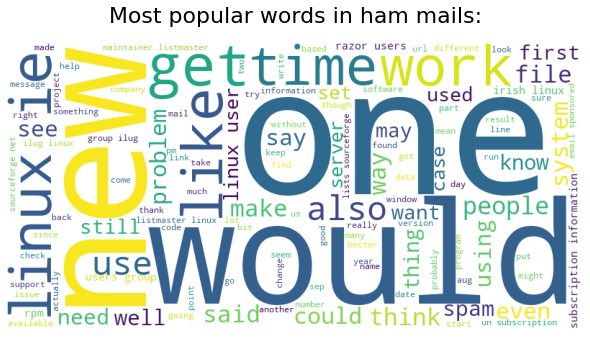

In [43]:
cloud_stopwords = ["urllink", "numberpresent", "mailing", "list"]

cloud = WordCloud(width = 800, height = 400, background_color = "white", stopwords = cloud_stopwords, min_font_size = 10)\
            .generate(" ".join(unprocessed_ham_words))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Most popular words in ham mails:", fontsize = 22, pad = 20)

plt.show() 

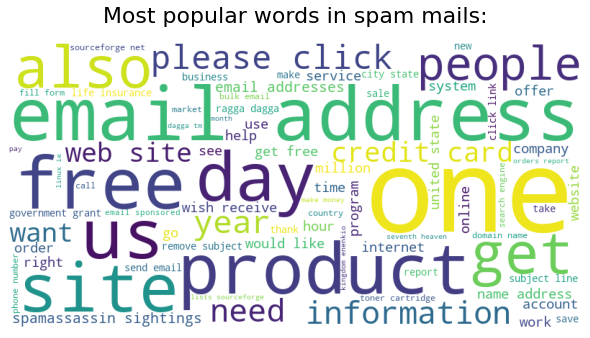

In [44]:
cloud = WordCloud(width = 800, height = 400, background_color = "white", stopwords = cloud_stopwords, min_font_size = 10)\
            .generate(" ".join(unprocessed_spam_words))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Most popular words in spam mails:", fontsize = 22, pad = 20)

plt.show() 

In [14]:
def identity_tokenizer(mail):
    return mail

tfidf_vectorizer = TfidfVectorizer(tokenizer = identity_tokenizer, lowercase = False, ngram_range = (1, 1))
train_features = tfidf_vectorizer.fit_transform(train_set[0])
test_features = tfidf_vectorizer.transform(test_set[0])

In [15]:
print(np.shape(train_features))
print(np.shape(test_features))

(4173, 31244)
(1792, 31244)


In [16]:
nb_classifier = MultinomialNB()
nb_classifier.fit(train_features, train_set[1])

print("Accuracy on the test set  = {:.3f}%".format(nb_classifier.score(test_features, test_set[1]) * 100))
predicted_y = nb_classifier.predict(test_features)

Accuracy on the test set  = 90.792%


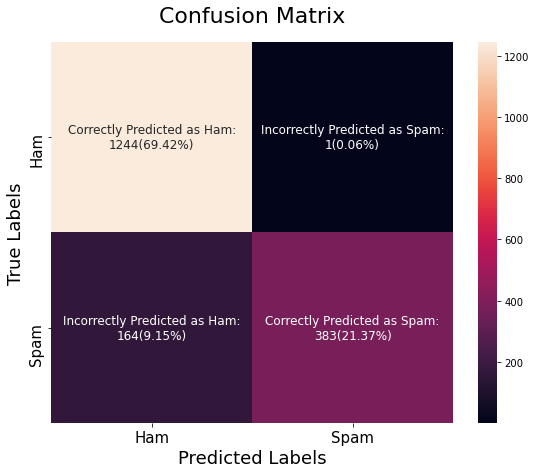

In [20]:
confusion = confusion_matrix(test_set[1], predicted_y)
test_mail_no = len(test_set[0])
confusion_str_matrix = [["Correctly Predicted as Ham:\n{}({:.2f}%)".format(confusion[0][0], confusion[0][0]/test_mail_no*100),\
                         "Incorrectly Predicted as Spam:\n{}({:.2f}%)".format(confusion[0][1], confusion[0][1]/test_mail_no*100)],\
                        ["Incorrectly Predicted as Ham:\n{}({:.2f}%)".format(confusion[1][0], confusion[1][0]/test_mail_no*100),\
                         "Correctly Predicted as Spam:\n{}({:.2f}%)".format(confusion[1][1], confusion[1][1]/test_mail_no*100)]]
fig, ax = plt.subplots(figsize = (9, 7))
ax = sns.heatmap(confusion, annot = confusion_str_matrix, fmt = 's', annot_kws = {"size": 12},\
                 xticklabels = ["Ham", "Spam"], yticklabels = ["Ham", "Spam"])
plt.title("Confusion Matrix", fontsize = 22, pad = 20)
plt.xlabel("Predicted Labels", fontsize = 18)
plt.ylabel("True Labels", fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [19]:
scores = precision_recall_fscore_support(test_set[1], predicted_y, average = "binary", pos_label = 1)
print("Precision =", scores[0])
print("Recall\t  =", scores[1])
print("F1 Score  =", scores[2])

Precision = 0.9973958333333334
Recall	  = 0.70018281535649
F1 Score  = 0.8227712137486574


In [94]:
print(spam_mails[0])

       Save up to 70% on Life Insurance.
Why Spend More Than You Have To? Life Quote Savings     
Ensuring your 
      family's financial security is very important. Life Quote Savings makes 
      buying life insurance simple and affordable. We Provide FREE Access to The 
      Very Best Companies and The Lowest Rates.   Life Quote Savings is FAST, EASY and 
            SAVES you money! Let us help you get started with the best values in 
            the country on new coverage. You can SAVE hundreds or even thousands 
            of dollars by requesting a FREE quote from Lifequote Savings. Our 
            service will take you less than 5 minutes to complete. Shop and 
            compare. SAVE up to 70% on all types of Life insurance!   Click Here For Your 
            Free Quote! Protecting your family is the best investment you'll ever 
          make!    
If you are in receipt of this email 
      in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMO

In [102]:
names = ["Ham", "Spam"]
print("Classified as:", names[nb_classifier.predict(tfidf_vectorizer.transform([process_email(spam_mails[0], 1)["words"]]))[0]])

Classified as: Spam


In [105]:
print(ham_mails[0])

Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues 
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com> 
  | I can't reproduce this error. For me it is very repeatable... (like every time, without fail). This is the debug log of the pick happening ... 18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ... Note, if I run the pick command by hand ... delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ... delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 ICT 2002] And the relevant part of my .mh_profile 

In [106]:
names = ["Ham", "Spam"]
print("Classified as:", names[nb_classifier.predict(tfidf_vectorizer.transform([process_email(ham_mails[0], 0)["words"]]))[0]])

Classified as: Ham
